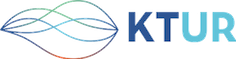

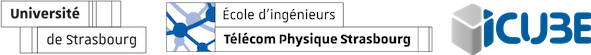

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.14

# Semantic segmentation

In this exercise you will create a U-Net network to perform the task of semantic segmentation on the images of pets.

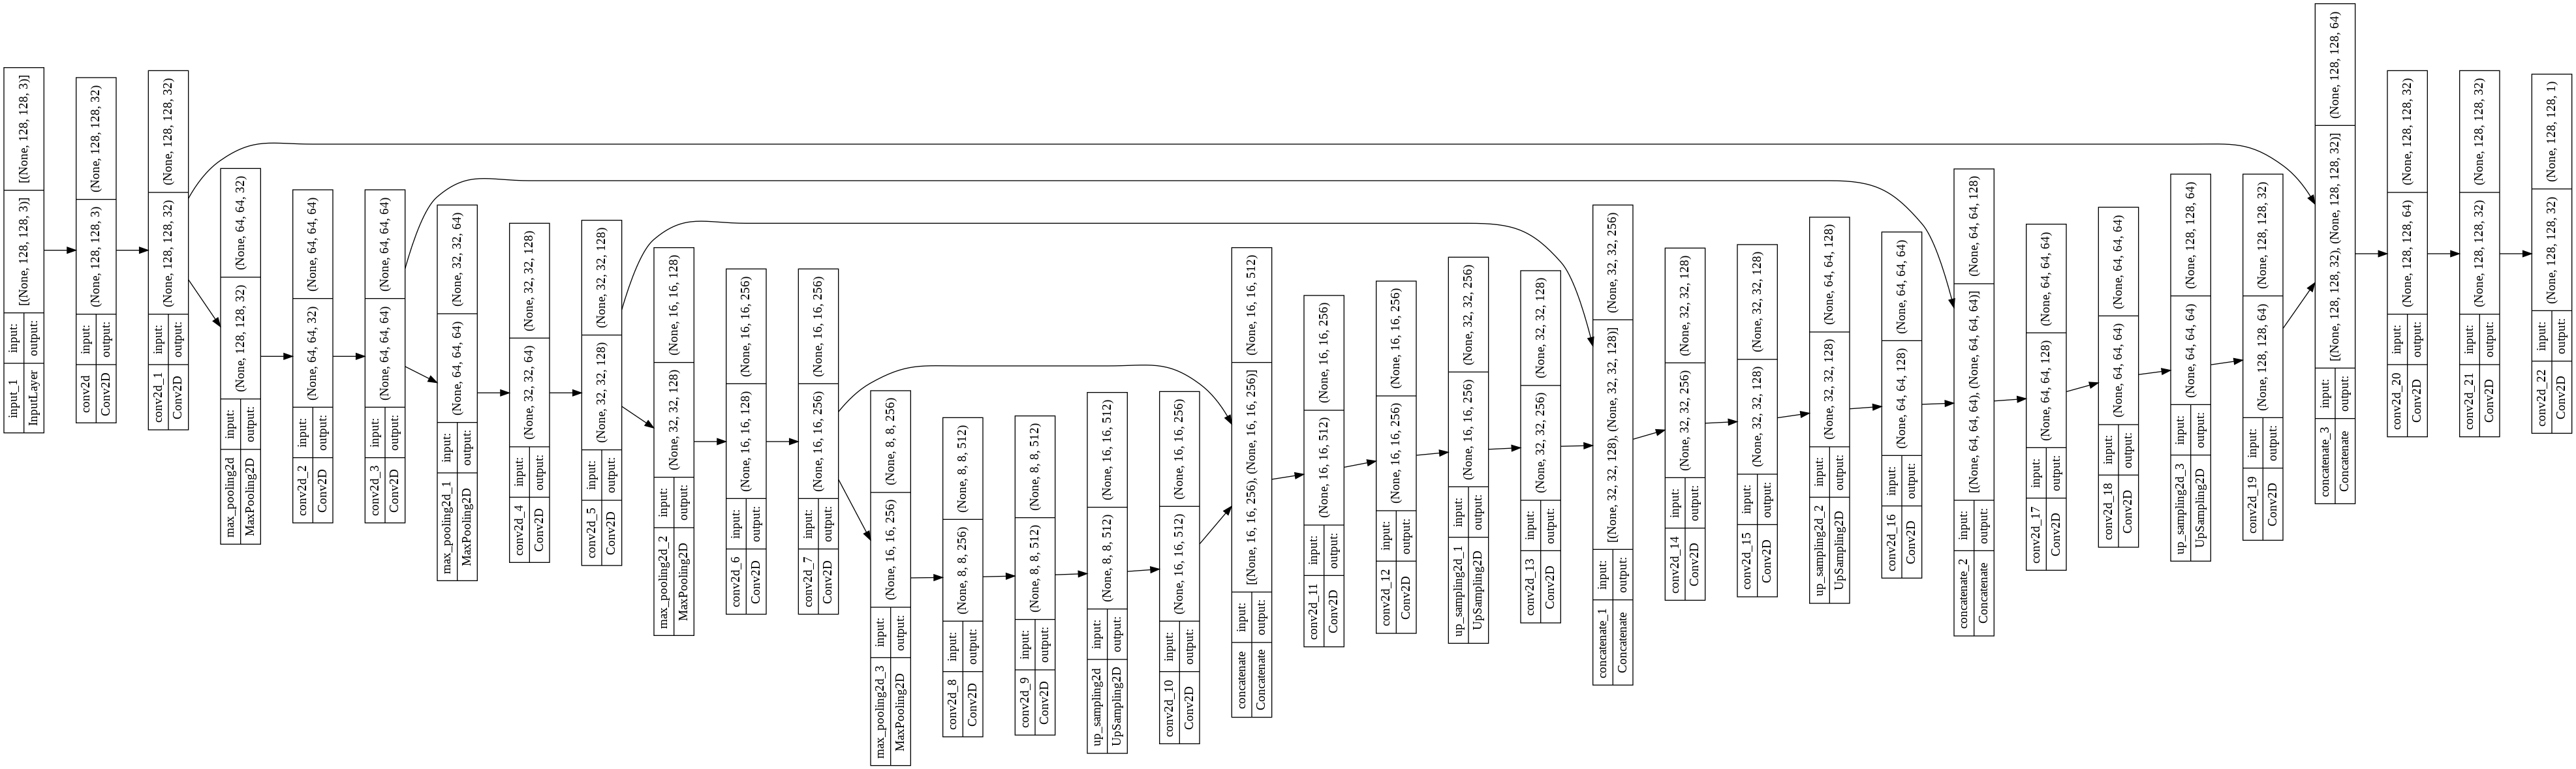

Install Tensorflow Addons library.

In [ ]:
!pip install tensorflow_addons

Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

## Loading data

### Download the dataset

Load Oxford-IIT Pet dataset

In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

### Inspect and rearrange the dataset

See info about the dataset

In [ ]:
print(info)

Look into the structure of the dataset

In [ ]:
dataset

Separate the train and test dataset

In [ ]:
trainDataset = dataset['train']
testDataset = dataset['test']

Remove the fields other than image and segmentation mask from the dataset.

In [ ]:
def load_image_and_mask(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   return input_image, input_mask

trainDataset = trainDataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
testDataset = testDataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

Original dataset has 3 classes in segmentation masks: 1 - pet, 2 - background and 3 - border. We will remove the border class, and join border pixels to the pet class. We will also change the class indexes to zero-based.

In [ ]:
def mask_remove_border(input_image, input_mask):
   # Put border class (3) to pet class (1)
   input_mask = tf.where(input_mask == 3, tf.ones_like(input_mask), input_mask)
   # We need zero-based index
   input_mask -= 1
   return input_image, input_mask

trainDataset = trainDataset.map(mask_remove_border, num_parallel_calls=tf.data.AUTOTUNE)
testDataset = testDataset.map(mask_remove_border, num_parallel_calls=tf.data.AUTOTUNE)

### Visualisations

Visualise the images and their masks

In [ ]:
plt.figure(figsize=(8, 30))
for i, (image, mask) in enumerate(trainDataset.take(9)):
    ax = plt.subplot(9, 2, 2*i + 1)
    plt.imshow(image)
    plt.axis("off")
    ax = plt.subplot(9, 2, 2*i + 2)
    plt.imshow(np.squeeze(mask))
    plt.axis("off")

### Preprocessing

Images in the dataset are of different sizes.

In [ ]:
for img, mask in trainDataset.take(4):
  print(img.shape)

Pixel values are integers from 0 to 255 which is not convenient for the training.

In [ ]:
for img, mask in trainDataset.take(1):
  print(img)

Masks: 0 for pets, 1 for the background

In [ ]:
for img, mask in trainDataset.take(1):
  print(mask)

Preprocess dataset. Resize all the images and masks to 128x128. Scale pixel values to between 0 and 1.

In [ ]:
HEIGHT = 128
WIDTH = 128

def preprocess(img, mask):
    img = tf.image.resize(img, [HEIGHT, WIDTH], method="nearest") / 255
    mask = tf.image.resize(mask, [HEIGHT, WIDTH], method="nearest")
    return img, mask

trainDataset = trainDataset.map(preprocess)
testDataset = testDataset.map(preprocess)

Set the batch size to 64. Take part of the test dataset as a validation dataset. Do some more optimisations, which will help in loading data faster.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = trainDataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_batches = train_batches.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = testDataset.take(2000).batch(BATCH_SIZE)
test_batches = testDataset.skip(2000).take(1669).batch(BATCH_SIZE)

## Build U-Net model for image segmentation

This time we will use Functional API to build the model. All of the convolutional layers except the last one have kernel size 3x3, padding "same", ReLU activation and "he_normal" kernel initializer.

### Build a model

TODO - Create a function for building a block of 2 convolutional layers.

In [ ]:
# TODO - Add your code here
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

TODO - Create a function for building downsample block, which consist of double convolutional block followed by a max-pooling layer. The function should return two tensors: features before and after max-pooling.

In [ ]:
# TODO - Add your code here
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D(2)(f)
   return f, p

TODO - Create a function for building upsample block. First, upsampling is done, followed by a convolutional layer. Then, skip connection is created, the resulting features are concatenated with *conv_features*, which come from the corresponding downsample block. Finally, upsample block ends with a double convolutional block.

In [ ]:
# TODO - Add your code here
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = UpSampling2D(size = (2,2))(x)
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # concatenate
   x = concatenate([x, conv_features])
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

TODO - Create a function for building a U-Net model. It should consist of 4 downsample blocks with 32, 64, 128, and 256 filters respectively, followed by a bottleneck - double convolutional block with 512 filters, followed by 4 upsampling blocks, with the same number of filters as downsample blocks but in reverse. Finally, last convolutional layer which should predict segmentation masks has 1 filter, kernel size 1x1, and sigmoid activation.

In [ ]:
 # TODO - Add your code here
 def build_unet_model():
   # inputs
   inputs = Input(shape=(HEIGHT,WIDTH,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 32)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 64)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 128)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 256)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 512)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 256)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 128)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 64)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 32)

   # outputs
   outputs = Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

   # unet model with Keras Functional API
   unet_model = Model(inputs, outputs, name="U-Net")

   return unet_model

Build U-Net model

In [ ]:
unet_model = build_unet_model()
unet_model.summary()

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

### Compile

Compile the model. Use Adam optimiser. Use binary IoU and binary accuracy as metrics.

In [ ]:
unet_model.compile(
  optimizer="adam",
  loss='binary_crossentropy',
  metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0,1], threshold=0.5), "binary_accuracy"])


### TensorBoard

In [ ]:
tb = TensorBoard(histogram_freq=1)

In [ ]:
%reload_ext tensorboard

### Saving to Google Drive

Mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Choose the folder to which you will save the model.

In [ ]:
path = F"/content/gdrive/My Drive/models/U-Net"

Creating the callback to save the best model.

In [ ]:
save_callback = ModelCheckpoint(
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                filepath=path,
                save_best_only=True,  # Only save a model if `val_loss` has improved.
                monitor="val_loss",
                verbose=1,
            )

### Training

Train the model for 10 epochs.

In [ ]:
NUM_EPOCHS = 10
unet_model.fit(train_batches, epochs=NUM_EPOCHS, validation_data=validation_batches, verbose=1, callbacks=[tb, save_callback])

### Analyzing

Run TensorBoard

In [ ]:
%tensorboard --logdir logs

Load the weights of the best model

In [ ]:
unet_model.load_weights(path)

Evaluate the model on the test dataset.

In [ ]:
unet_model.evaluate(test_batches)

Visualise the predictions.

In [ ]:
def show_predictions(test_batches, num_img=9):
  test_ds_1_batch = test_batches.take(1)
  pred_mask_1_batch = unet_model.predict(test_ds_1_batch)
  pred_mask_1_batch = (pred_mask_1_batch > 0.5).astype(np.uint8)

  plt.figure(figsize=(12, 30))

  for img_batch, mask_batch in test_ds_1_batch:
    img_batch_arr = img_batch.numpy()
    mask_batch_arr = mask_batch.numpy()
    for i in range(9):
      ax = plt.subplot(9, 3, 3*i + 1)
      plt.imshow(img_batch_arr[i])
      plt.axis("off")
      plt.title("Input image")
      ax = plt.subplot(9, 3, 3*i + 2)
      plt.imshow(np.squeeze(mask_batch_arr[i]))
      plt.axis("off")
      plt.title("True mask")
      ax = plt.subplot(9, 3, 3*i + 3)
      plt.imshow(np.squeeze(pred_mask_1_batch[i]))
      plt.axis("off")
      plt.title("Predicted mask")

In [ ]:
show_predictions(test_batches)

But what if the distribution of the test set is slightly different than that of the training set? For example, if test images are more rotated?

### Rotated test set

Add some rotations to a test set.

Install Tensorflow Addons library which contains rotation function.

In [ ]:
!pip install tensorflow_addons

Prepare the rotation function for augmenting.

In [ ]:
def rotate(input_image, input_mask, factor):
   angle = tf.random.uniform(shape=[], minval=-factor, maxval=factor) * np.pi*2
   input_image = tfa.image.rotate(input_image, angle, fill_mode="reflect")
   input_mask = tfa.image.rotate(input_mask, angle, fill_mode="reflect")
   return input_image, input_mask

def augment(input_image, input_mask):
   input_image, input_mask = rotate(input_image, input_mask, 0.1)
   return input_image, input_mask

Augment test set with rotations going from 0 to 0.2*2*pi.

In [ ]:
testDataset_rot = testDataset.map(augment)
test_batches_rot = testDataset_rot.skip(2000).take(1669).batch(BATCH_SIZE)

Evaluate the model on the rotated data.

In [ ]:
unet_model.evaluate(test_batches_rot)

Normally, you should get weaker result than before. The model seems to be sensitive to the rotation.

Visualise the results.

In [ ]:
show_predictions(test_batches_rot)

### Delete the model

In [ ]:
del unet_model
tf.keras.backend.clear_session()

## Optimise U-Net

In this section we will optimise the performance of U-Net by adding data augmentation, batch normalization, and dropout.

### Augmentation

Different augmentation functions.

In [ ]:
def flip(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

def rotate(input_image, input_mask, factor):
    # rotate by a random angle
    angle = tf.random.uniform(shape=[], minval=-factor, maxval=factor) * np.pi*2
    input_image = tfa.image.rotate(input_image, angle, fill_mode="reflect")
    input_mask = tfa.image.rotate(input_mask, angle, fill_mode="reflect")
    return input_image, input_mask

def brightness(input_image, factor):
    # random brightness adjustment illumination
    input_image = tf.image.random_brightness(input_image, factor)
    input_image = tf.clip_by_value(input_image, 0, 1)
    return input_image

def contrast(input_image, factor):
    # random contrast adjustment
    input_image = tf.image.random_contrast(input_image, factor[0], factor[1])
    input_image = tf.clip_by_value(input_image, 0, 1)
    return input_image

def crop_and_resize(input_image, input_mask, factor):
    if tf.random.uniform(()) < 0.3:
        # crop
        input_image = tf.image.central_crop(input_image, factor)
        input_mask = tf.image.central_crop(input_mask, factor)
        # resize
        input_image = tf.image.resize(input_image, (HEIGHT, WIDTH))
        input_mask = tf.cast(tf.image.resize(input_mask, (HEIGHT, WIDTH)), tf.uint8)
    return input_image, input_mask

Prepare the augmentation function for mapping.

In [ ]:
def augment(input_image, input_mask):
   input_image, input_mask = flip(input_image, input_mask)
   input_image, input_mask = rotate(input_image, input_mask, 0.1)
   input_image = brightness(input_image, 0.2)
   input_image = contrast(input_image, (0.7, 1.3))
   input_image, input_mask = crop_and_resize(input_image, input_mask, 0.75)
   return input_image, input_mask

Augment the training dataset.

In [ ]:
trainDataset_aug = trainDataset.map(augment)

Visualise different effects of augmentation on the same image.

In [ ]:
plt.figure(figsize=(15, 10))
for i, (img, mask) in enumerate(trainDataset_aug.skip(1).take(1).repeat(6)):
  ax = plt.subplot(3, 4, i*2 + 1)
  plt.imshow(img)
  plt.axis("off")
  ax = plt.subplot(3, 4, i*2 + 2)
  mask = np.squeeze(mask)
  plt.imshow(mask)
  plt.axis("off")

TODO - Go back and try different values of the parameters for different augmentations. Visualise the results to get a feeling of the changes. Choose the values of the parameters that you think give the best results. A good augmentation should bring diversity to the training set, improve the generalisation of the model, and increase the results, but be careful, too strong augmentation can hurt the performance.

Set the batch size, do some more dataset optimisations.

In [ ]:
train_batches_aug = trainDataset_aug.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_batches_aug = train_batches_aug.prefetch(buffer_size=tf.data.AUTOTUNE)

### Build a model

TODO - Redo *double_conv_block* function, add batch norm after each convolutional layer.

In [ ]:
# TODO - Add your code here
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = BatchNormalization()(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = BatchNormalization()(x)
   return x

TODO - Redo *downsample_block* function, add Dropout with the rate of 0.3 after max-pooling.

In [ ]:
# TODO - Add your code here
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D(2)(f)
   p = Dropout(0.3)(p)
   return f, p

TODO - Redo *upsample_block* function, add batch norm after a convolutional layer, and add Dropout with the rate of 0.3 after concatenating.

In [ ]:
# TODO - Add your code here
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = UpSampling2D(size = (2,2))(x)
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = BatchNormalization()(x)
   # concatenate
   x = concatenate([x, conv_features])
   # dropout
   x = Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

Create and compile U-Net.

In [ ]:
unet_model = build_unet_model()

unet_model.compile(
  optimizer="adam",
  loss='binary_crossentropy',
  metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0,1], threshold=0.5), "binary_accuracy"])

### TensorBoard

In [ ]:
tb = TensorBoard(histogram_freq=1)
%reload_ext tensorboard

### Saving

Choose the folder to which you will save the model (different from a previous one).

In [ ]:
path = F"/content/gdrive/My Drive/models/U-Net_optimised"

Creating the callback to save the best model.

In [ ]:
save_callback = ModelCheckpoint(
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                filepath=path,
                save_best_only=True,  # Only save a model if `val_loss` has improved.
                monitor="val_loss",
                verbose=1,
            )


### Training

In [ ]:
NUM_EPOCHS = 10
unet_model.fit(train_batches_aug, epochs=NUM_EPOCHS, validation_data=validation_batches, verbose=1, callbacks=[tb, save_callback])

### Analyzing

In [ ]:
%tensorboard --logdir logs

In [ ]:
unet_model.load_weights(path)

In [ ]:
unet_model.evaluate(test_batches)

In [ ]:
show_predictions(test_batches)

### Rotated test set

Evaluate the model on the rotated data.

In [ ]:
unet_model.evaluate(test_batches_rot)

### Delete the model

In [ ]:
del unet_model
tf.keras.backend.clear_session()